<a href="https://colab.research.google.com/github/AbhimanyuAryan/Planet_Amazon_Prediction_Kaggle/blob/master/planet_amazon_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
torchvision 0.2.2.post2 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [2]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhimanyuaryan","key":"47b4b1212f86569966b97f04e65b7ea8"}'}

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Mar  5 09:01 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [8]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [9]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
!unzip -q -n {path}/train_v2.csv.zip -d {path}

100% 599M/600M [00:11<00:00, 71.1MB/s]
100% 600M/600M [00:11<00:00, 52.7MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 19.2MB/s]


In [10]:
# extracting stuff
! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

In [12]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

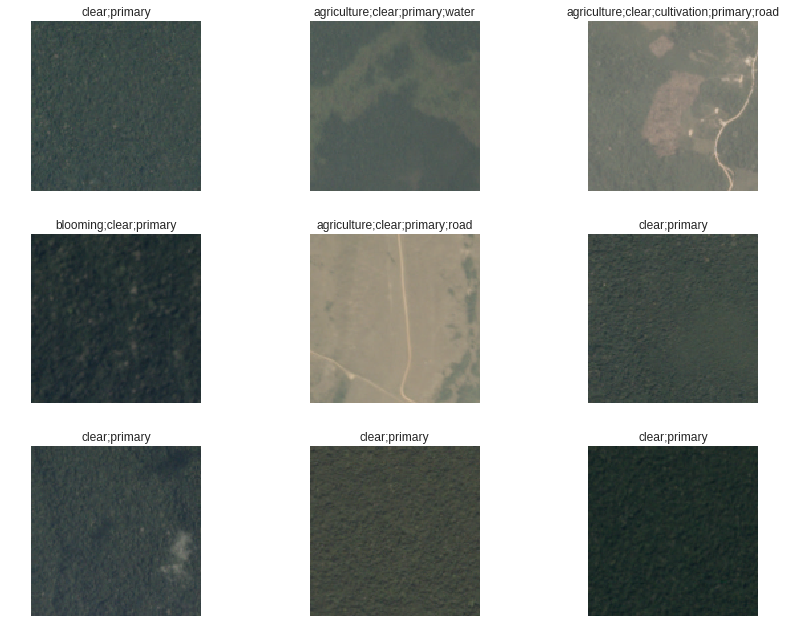

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 44407654.79it/s]


We use the LR Finder to pick a good learning rate.

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


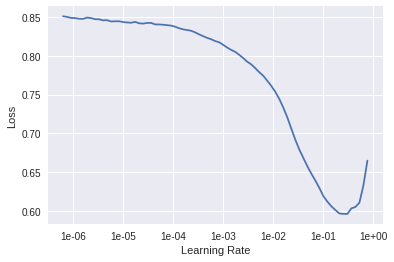

In [20]:
learn.recorder.plot()


In [0]:
lr = 0.01

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.128323,0.106885,0.947455,0.906153,03:46
2,0.110183,0.095821,0.950848,0.917087,03:42
3,0.101208,0.090892,0.954351,0.921661,03:43
4,0.094213,0.087758,0.955317,0.923920,03:42
5,0.092344,0.087107,0.955906,0.924815,03:41


In [0]:
learn.save('stage-2-rn50')

In [24]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


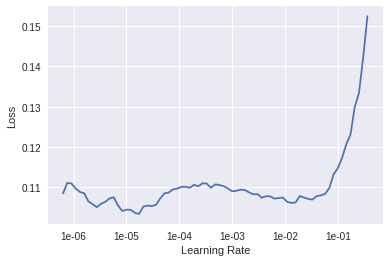

In [26]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.095723,0.088680,0.953988,0.920998,11:08
2,0.093739,0.088264,0.959641,0.923458,11:06
3,0.093522,0.085125,0.959081,0.926731,11:12
4,0.089943,0.083361,0.958166,0.928540,11:06
5,0.085670,0.083393,0.958943,0.928290,11:07


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
1,0.091120,0.088330,0.955688,0.924401,14:31
2,0.091686,0.087004,0.956233,0.923294,14:26
3,0.087286,0.083736,0.956218,0.927747,14:29
4,0.081722,0.081268,0.958827,0.930248,14:29
5,0.078439,0.080780,0.959321,0.930447,14:30


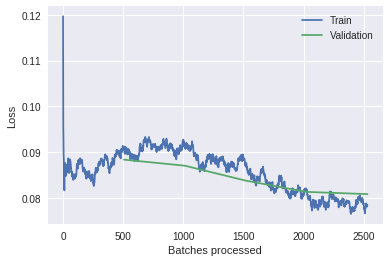

In [32]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')


In [0]:
learn.export()

## Final Submission

In [35]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  

100% 602M/603M [00:11<00:00, 29.4MB/s]
100% 603M/603M [00:11<00:00, 55.8MB/s]


In [37]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 98% 297M/304M [00:06<00:00, 65.3MB/s]
100% 304M/304M [00:06<00:00, 51.2MB/s]
5


In [38]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [41]:
labelled_preds[:5]

['clear primary',
 'clear primary',
 'cloudy',
 'agriculture clear primary road',
 'agriculture clear cultivation haze primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [45]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "Abhimanyu's Submission"

100% 2.21M/2.21M [00:08<00:00, 283kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space